Pentru compilare este necesar un folder "pocket_cube" in care sa se gaseasca: constants.py, cube.py, moves.py.

Cerinta 1: A* si Bidirectional BFS

Mai intai dorim sa verificam cum arata starea cubului (array) dupa aplicarea anumitor miscari (test cases).

In [ ]:
from pocket_cube.cube import Cube, Move

# Initialize a cube
cube = Cube("R U' R' F' U")

# Print the final state of the cube
print(cube.state)

[2 5 5 0 1 1 4 2 2 2 3 4 3 5 0 0 4 4 1 0 3 1 3 5]


Definim 3 euristici pentru A*, cu eficiente diferite.

In [ ]:
# Heuristic function h1: Counts the number of misplaced tiles in the current state
def h1(state):
    goal_state = np.repeat(np.arange(6), 4).reshape((6, 4))
    return np.sum(np.array(state).reshape((6, 4)) != goal_state)

In [ ]:
# Evaluates the number of misplaced tiles and the number of unsolved faces to estimate the distance
# from the goal state in a cube-solving problem.
def h1(state):
    # Count the number of misplaced tiles
    misplaced_tiles = np.sum(np.array(state) != np.repeat(np.arange(6), 4))

    # Count the number of solved faces (each face has 4 solved tiles)
    solved_faces = np.sum(np.sum(np.array(state).reshape((6, 4)) == np.arange(4), axis=1) == 4)

    # Sum of misplaced tiles and unsolved faces
    heuristic_value = misplaced_tiles + 0.5 * (6 - solved_faces)

    return heuristic_value

In [ ]:
# A more efficient heuristic function that considers positions and orientations to estimate the distance
# from the goal state in a cube-solving problem.
def h1(state):
    state_matrix = np.array(state).reshape((6, 4))
    goal_state = np.repeat(np.arange(6), 4).reshape((6, 4))

    # Count the number of misplaced tiles
    misplaced_tiles = np.sum(state_matrix != goal_state)

    # Calculate the Manhattan distance for each cubelet's position
    manhattan_positions = np.sum(np.abs(np.indices((6, 4)) - np.indices((6, 4), dtype=int)[:, :, None, None]) * (state_matrix != goal_state), axis=0)

    # Calculate the orientation differences for each cubelet
    orientation_diff = np.sum(state_matrix != goal_state, axis=1)

    # Sum of misplaced tiles, Manhattan distances, and orientation differences
    heuristic_value = misplaced_tiles + 0.5 * np.sum(manhattan_positions) + 0.25 * np.sum(orientation_diff)

    return (heuristic_value + 1) // 2  # To make the heuristic admissible

Vom folosi a doua euristica pentru a avea un raport bun timp-eficienta (sub 10 secunde).

In [ ]:
import time
from heapq import heappop, heappush
from pocket_cube.cube import Cube, Move
import numpy as np

# Evaluates the number of misplaced tiles and the number of unsolved faces to estimate the distance
# from the goal state in a cube-solving problem.
def h1(state):
    # Count the number of misplaced tiles
    misplaced_tiles = np.sum(np.array(state) != np.repeat(np.arange(6), 4))

    # Count the number of solved faces (each face has 4 solved tiles)
    solved_faces = np.sum(np.sum(np.array(state).reshape((6, 4)) == np.arange(4), axis=1) == 4)

    # Sum of misplaced tiles and unsolved faces
    heuristic_value = misplaced_tiles + 0.5 * (6 - solved_faces)

    return heuristic_value

# A* search algorithm
def astar(cube, heuristic):
    start_time = time.time()

    # Convert the start and goal states to tuples for hashing
    start_state = tuple(cube.clone_state())
    goal_state = tuple(np.repeat(np.arange(6), 4))

    # Initialize the frontier with the initial state
    frontier = [(heuristic(start_state), start_state, None, None)]

    # Dictionary to keep track of discovered states and their properties
    discovered = {start_state: (None, 0, None)}

    while frontier:
        # Pop the state with the lowest cost from the priority queue (frontier)
        _, current_state, parent_state, last_move = heappop(frontier)
        current_g = discovered[current_state][1]

        # Check if the goal state is reached
        if current_state == goal_state:
            execution_time = time.time() - start_time

            # Reconstruct the path from goal to start
            path, moves = [], []
            while parent_state is not None:
                moves.append(last_move.name if last_move else 'Initial')
                current_state, _, last_move = discovered[current_state]
                parent_state = current_state

            moves.append(None)
            return execution_time, len(discovered), moves[::-1]

        # Explore neighboring states
        for move_enum in Move:
            move = move_enum.value
            new_state = tuple(Cube.move_state(np.array(current_state), move).tolist())
            new_g = current_g + 1

            # Update the discovered states if a shorter path is found
            if new_state not in discovered or new_g < discovered[new_state][1]:
                discovered[new_state] = (current_state, new_g, move_enum)
                heappush(frontier, (new_g + heuristic(new_state), new_state, current_state, move_enum))

    # If no solution is found
    return float('inf'), len(discovered), float('inf'), None

# Test cases
test_cases = [
    "R U' R' F' U",
    "F' R U R U F' U'",
    "F U U F' U' R R F' R",
    "U' R U' F' R F F U' F U U"
]

# Run A* search for each test case
for case in test_cases:
    cube = Cube(case)

    # Run A* with the h1 heuristic
    execution_time, num_states, moves = astar(cube, h1)

    # Print results for each test case
    print(f"Test Case: {case}")
    if execution_time == float('inf'):
        print("No solution found")
    else:
        print(f"Execution Time: {execution_time:.6f}s")
        print(f"Number of States Discovered: {num_states}")
        print(f"Solution Path Length: {len(moves) - 1}")
        print("Solution Path:")
        for move in moves[:-1]:
            print(f"Move: {move}")
    print()


Test Case: R U' R' F' U
Execution Time: 0.039052s
Number of States Discovered: 612
Solution Path Length: 6
Solution Path:
Move: None
Move: Up
Move: F
Move: R
Move: U
Move: Rp

Test Case: F' R U R U F' U'
Execution Time: 0.037921s
Number of States Discovered: 360
Solution Path Length: 8
Solution Path:
Move: None
Move: Rp
Move: Up
Move: Fp
Move: R
Move: F
Move: Rp
Move: F

Test Case: F U U F' U' R R F' R
Execution Time: 1.599107s
Number of States Discovered: 16734
Solution Path Length: 10
Solution Path:
Move: None
Move: Rp
Move: F
Move: Rp
Move: Rp
Move: U
Move: F
Move: U
Move: U
Move: Fp

Test Case: U' R U' F' R F F U' F U U
Execution Time: 7.595205s
Number of States Discovered: 91464
Solution Path Length: 12
Solution Path:
Move: None
Move: R
Move: Fp
Move: R
Move: Fp
Move: Fp
Move: Up
Move: F
Move: U
Move: U
Move: F
Move: Up



BFS bidirectional:

In [ ]:
from pocket_cube.cube import Cube, Move
import time
from collections import deque
import numpy as np

def bidirectional_bfs(cube):
    # Record the start time for measuring execution time
    start_time = time.time()

    # Get the initial and goal states
    start_state = cube.clone_state()
    goal_state = np.repeat(np.arange(6), 4)

    # Initialize queues for forward and backward BFS
    start_queue = deque([(tuple(start_state), [])])
    goal_queue = deque([(tuple(goal_state), [])])

    # Initialize sets to keep track of visited states for each direction
    start_visited = set([tuple(start_state)])
    goal_visited = set([tuple(goal_state)])

    while start_queue and goal_queue:
        # Forward BFS
        current_state, path = start_queue.popleft()

        for move_enum in Move:
            move = move_enum.value
            new_state = Cube.move_state(np.array(current_state), move)
            new_state_tuple = tuple(new_state)

            # Check if the new state has not been visited
            if new_state_tuple not in start_visited:
                start_queue.append((new_state_tuple, path + [move_enum]))
                start_visited.add(new_state_tuple)

                # If the new state is also visited in the backward direction, a solution is found
                if new_state_tuple in goal_visited:
                    execution_time = time.time() - start_time
                    path_length = len(path) + len(goal_queue[-1][1])
                    return execution_time, len(start_visited) + len(goal_visited), path_length, path + goal_queue[-1][1]

        # Backward BFS
        current_state, path = goal_queue.popleft()

        for move_enum in Move:
            move = move_enum.value
            new_state = Cube.move_state(np.array(current_state), move)
            new_state_tuple = tuple(new_state)

            # Check if the new state has not been visited
            if new_state_tuple not in goal_visited:
                goal_queue.append((new_state_tuple, path + [move_enum]))
                goal_visited.add(new_state_tuple)

                # If the new state is also visited in the forward direction, a solution is found
                if new_state_tuple in start_visited:
                    execution_time = time.time() - start_time
                    path_length = len(start_queue[-1][1]) + len(path)
                    return execution_time, len(start_visited) + len(goal_visited), path_length, start_queue[-1][1] + path

    # If no solution is found
    return float('inf'), len(start_visited) + len(goal_visited), float('inf'), None

# Test cases
test_cases = [
    "R U' R' F' U",
    "F' R U R U F' U'",
    "F U U F' U' R R F' R",
    "U' R U' F' R F F U' F U U"
]

for case in test_cases:
    cube = Cube(case)
    execution_time, num_states, path_length, solution_path = bidirectional_bfs(cube)
    print(f"Test Case: {case}")
    print(f"Execution Time: {execution_time:.6f}s")
    print(f"Number of States Discovered: {num_states}")
    print(f"Solution Path Length: {path_length}")
    print("Solution Path:")
    print(" -> ".join([move_enum.name for move_enum in solution_path]))
    print()


Test Case: R U' R' F' U
Execution Time: 0.001415s
Number of States Discovered: 111
Solution Path Length: 5
Solution Path:
R -> Up -> Fp -> R -> Up

Test Case: F' R U R U F' U'
Execution Time: 0.018106s
Number of States Discovered: 783
Solution Path Length: 7
Solution Path:
U -> F -> Up -> U -> F -> Rp -> Up

Test Case: F U U F' U' R R F' R
Execution Time: 0.040985s
Number of States Discovered: 2720
Solution Path Length: 9
Solution Path:
F -> U -> U -> Fp -> Up -> F -> U -> U -> Fp

Test Case: U' R U' F' R F F U' F U U
Execution Time: 0.126685s
Number of States Discovered: 8304
Solution Path Length: 11
Solution Path:
R -> Fp -> R -> F -> F -> R -> Fp -> R -> F -> R -> Up



Grafice:

In [ ]:
%matplotlib inline
import time
from heapq import heappop, heappush
from pocket_cube.cube import Cube, Move
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# Evaluates the number of misplaced tiles and the number of unsolved faces to estimate the distance
# from the goal state in a cube-solving problem.
def h1(state):
    # Count the number of misplaced tiles
    misplaced_tiles = np.sum(np.array(state) != np.repeat(np.arange(6), 4))

    # Count the number of solved faces (each face has 4 solved tiles)
    solved_faces = np.sum(np.sum(np.array(state).reshape((6, 4)) == np.arange(4), axis=1) == 4)

    # Sum of misplaced tiles and unsolved faces
    heuristic_value = misplaced_tiles + 0.5 * (6 - solved_faces)

    return heuristic_value

# A* search algorithm
def astar(cube, heuristic):
    start_time = time.time()

    # Convert the start and goal states to tuples for hashing
    start_state = tuple(cube.clone_state())
    goal_state = tuple(np.repeat(np.arange(6), 4))

    # Initialize the frontier with the initial state
    frontier = [(heuristic(start_state), start_state, None, None)]

    # Dictionary to keep track of discovered states and their properties
    discovered = {start_state: (None, 0, None)}

    while frontier:
        # Pop the state with the lowest cost from the priority queue (frontier)
        _, current_state, parent_state, last_move = heappop(frontier)
        current_g = discovered[current_state][1]

        # Check if the goal state is reached
        if current_state == goal_state:
            execution_time = time.time() - start_time

            # Reconstruct the path from goal to start
            path, moves = [], []
            while parent_state is not None:
                moves.append(last_move.name if last_move else 'Initial')
                current_state, _, last_move = discovered[current_state]
                parent_state = current_state

            moves.append(None)
            return execution_time, len(discovered), moves[::-1]

        # Explore neighboring states
        for move_enum in Move:
            move = move_enum.value
            new_state = tuple(Cube.move_state(np.array(current_state), move).tolist())
            new_g = current_g + 1

            # Update the discovered states if a shorter path is found
            if new_state not in discovered or new_g < discovered[new_state][1]:
                discovered[new_state] = (current_state, new_g, move_enum)
                heappush(frontier, (new_g + heuristic(new_state), new_state, current_state, move_enum))

    # If no solution is found
    return float('inf'), len(discovered), float('inf'), None

def bidirectional_bfs(cube):
    # Record the start time for measuring execution time
    start_time = time.time()

    # Get the initial and goal states
    start_state = cube.clone_state()
    goal_state = np.repeat(np.arange(6), 4)

    # Initialize queues for forward and backward BFS
    start_queue = deque([(tuple(start_state), [])])
    goal_queue = deque([(tuple(goal_state), [])])

    # Initialize sets to keep track of visited states for each direction
    start_visited = set([tuple(start_state)])
    goal_visited = set([tuple(goal_state)])

    while start_queue and goal_queue:
        # Forward BFS
        current_state, path = start_queue.popleft()

        for move_enum in Move:
            move = move_enum.value
            new_state = Cube.move_state(np.array(current_state), move)
            new_state_tuple = tuple(new_state)

            # Check if the new state has not been visited
            if new_state_tuple not in start_visited:
                start_queue.append((new_state_tuple, path + [move_enum]))
                start_visited.add(new_state_tuple)

                # If the new state is also visited in the backward direction, a solution is found
                if new_state_tuple in goal_visited:
                    execution_time = time.time() - start_time
                    path_length = len(path) + len(goal_queue[-1][1])
                    return execution_time, len(start_visited) + len(goal_visited), path_length, path + goal_queue[-1][1]

        # Backward BFS
        current_state, path = goal_queue.popleft()

        for move_enum in Move:
            move = move_enum.value
            new_state = Cube.move_state(np.array(current_state), move)
            new_state_tuple = tuple(new_state)

            # Check if the new state has not been visited
            if new_state_tuple not in goal_visited:
                goal_queue.append((new_state_tuple, path + [move_enum]))
                goal_visited.add(new_state_tuple)

                # If the new state is also visited in the forward direction, a solution is found
                if new_state_tuple in start_visited:
                    execution_time = time.time() - start_time
                    path_length = len(start_queue[-1][1]) + len(path)
                    return execution_time, len(start_visited) + len(goal_visited), path_length, start_queue[-1][1] + path

    # If no solution is found
    return float('inf'), len(start_visited) + len(goal_visited), float('inf'), None

# Test cases
test_cases = [
    "R U' R' F' U",
    "F' R U R U F' U'",
    "F U U F' U' R R F' R",
    "U' R U' F' R F F U' F U U"
]

test_cases_for_bars = [
    "case1",
    "case2",
    "case3",
    "case4"
]

# Lists to store the results for A* and bidirectional BFS
a_star_results = []
bfs_results = []

# Run tests and collect results for A* and bidirectional BFS
for case in test_cases:
    # A*
    cube = Cube(case)
    a_star_results.append(astar(cube, h1))

    # Bidirectional BFS
    cube = Cube(case)
    bfs_results.append(bidirectional_bfs(cube))

# Extracting specific values for plotting
a_star_execution_times = [result[0] for result in a_star_results]
a_star_num_states = [result[1] for result in a_star_results]
a_star_paths = [result[2] for result in a_star_results]

# Extracting specific values for plotting
bfs_execution_times = [result[0] for result in bfs_results]
bfs_num_states = [result[1] for result in bfs_results]
bfs_paths = [result[2] for result in bfs_results]
bfs_path_lengths = [path if path is not None else 0 for path in bfs_paths]

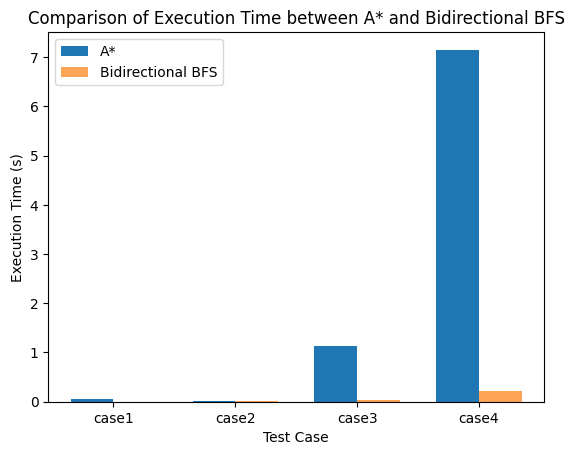

In [ ]:
# Bar chart for execution time
bar_width = 0.35
index = np.arange(len(test_cases))
plt.bar(index, a_star_execution_times, bar_width, label='A*')
plt.bar(index + bar_width, bfs_execution_times, bar_width, label='Bidirectional BFS', alpha=0.7)
plt.xlabel('Test Case')
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Time between A* and Bidirectional BFS')
plt.xticks(index + bar_width / 2, test_cases_for_bars)
plt.legend()
plt.show()

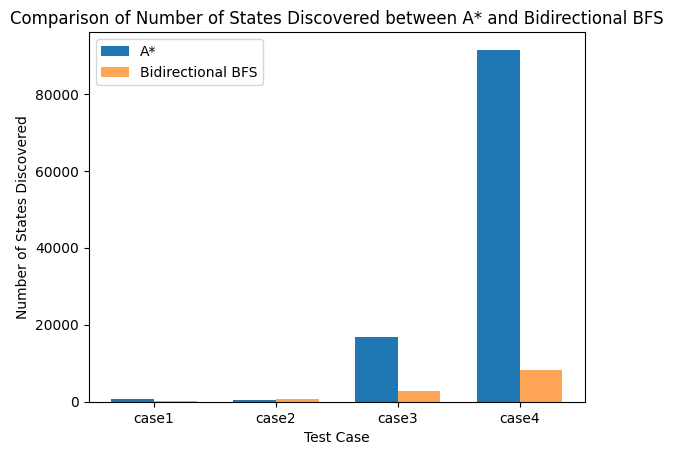

In [ ]:
# Bar chart for number of states discovered
plt.bar(index, a_star_num_states, bar_width, label='A*')
plt.bar(index + bar_width, bfs_num_states, bar_width, label='Bidirectional BFS', alpha=0.7)
plt.xlabel('Test Case')
plt.ylabel('Number of States Discovered')
plt.title('Comparison of Number of States Discovered between A* and Bidirectional BFS')
plt.xticks(index + bar_width / 2, test_cases_for_bars)
plt.legend()
plt.show()

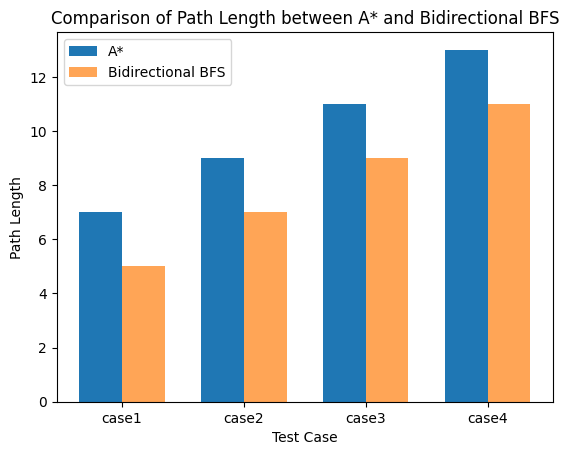

In [ ]:
# Extracting specific values for plotting
a_star_path_lengths = [len(result[2]) if result[2] is not None else 0 for result in a_star_results]
bfs_path_lengths = [result[2] if result[2] is not None else 0 for result in bfs_results]

# Bar chart for path length
plt.bar(index, a_star_path_lengths, bar_width, label='A*')
plt.bar(index + bar_width, bfs_path_lengths, bar_width, label='Bidirectional BFS', alpha=0.7)
plt.xlabel('Test Case')
plt.ylabel('Path Length')
plt.title('Comparison of Path Length between A* and Bidirectional BFS')
plt.xticks(index + bar_width / 2, test_cases_for_bars)
plt.legend()
plt.show()


Cerinta 2: Monte Carlo Tree Search

In [ ]:
# calculates the number of misplaced tiles in a cube-solving problem.
# It ignores the count of solved faces, providing a non-admissible heuristic.
def h2(state):
    # Count the number of misplaced tiles (same as h1)
    misplaced_tiles = np.sum(np.array(state) != np.repeat(np.arange(6), 4))

    # Ignore the solved faces count (set to 0)
    heuristic_value = misplaced_tiles

    return heuristic_value

Cerinta 3: Pattern database


In [ ]:
from pocket_cube.cube import Cube, Move
from collections import deque
import numpy as np
import time

def build_pattern_database(max_distance):
    # Record the start time for measuring construction time
    start_time = time.time()

    # Define the goal state (solved state)
    goal_state = np.repeat(np.arange(6), 4)
    goal_state_tuple = tuple(goal_state)

    # Initialize the pattern database and the queue for BFS
    pattern_database = {}
    queue = deque([(goal_state_tuple, 0)])

    # Perform BFS to construct the pattern database
    while queue:
        current_state, distance = queue.popleft()

        # Record the distance for the current state in the pattern database
        pattern_database[current_state] = distance

        # If the desired maximum distance is reached, skip further exploration
        if distance >= max_distance:
            continue

        # Explore neighboring states by applying all possible moves
        for move_enum in Move:
            move = move_enum.value
            new_state = Cube.move_state(np.array(current_state), move)
            new_state_tuple = tuple(new_state)

            # If the new state is not in the pattern database, add it to the queue
            if new_state_tuple not in pattern_database:
                queue.append((new_state_tuple, distance + 1))
                pattern_database[new_state_tuple] = distance + 1

    # Calculate and print the construction time and the number of states in the pattern database
    construction_time = time.time() - start_time
    print(f"Pattern Database Construction Time: {construction_time:.6f}s")
    print(f"Number of States in the Pattern Database: {len(pattern_database)}")

    # Print the last 5 states and their distances for verification
    last_states = list(pattern_database.keys())[-5:]
    print("Last 5 States and Distances:")
    for state in last_states:
        distance = pattern_database[state]
        print(f"State: {state}, Distance to Goal: {distance}")

# Set your desired maximum distance
max_distance = 7

# Build pattern database and print the time
build_pattern_database(max_distance)

Pattern Database Construction Time: 0.939191s
Number of States in the Pattern Database: 44971
Last 5 States and Distances:
State: (0, 0, 0, 1, 3, 1, 2, 4, 2, 2, 0, 3, 3, 1, 5, 1, 4, 4, 5, 5, 4, 5, 2, 3), Distance to Goal: 7
State: (0, 4, 5, 1, 1, 4, 0, 5, 3, 2, 3, 2, 3, 1, 5, 3, 4, 0, 5, 2, 2, 4, 1, 0), Distance to Goal: 7
State: (0, 0, 0, 2, 4, 2, 1, 3, 1, 2, 0, 3, 3, 1, 5, 1, 4, 5, 5, 3, 4, 4, 2, 5), Distance to Goal: 7
State: (0, 2, 5, 4, 5, 1, 1, 4, 2, 2, 0, 5, 3, 1, 3, 2, 4, 4, 5, 3, 1, 0, 0, 3), Distance to Goal: 7
State: (0, 0, 5, 2, 4, 1, 1, 5, 4, 2, 2, 5, 3, 1, 3, 2, 4, 0, 5, 3, 1, 4, 0, 3), Distance to Goal: 7


In [ ]:
def h3(state, pattern_database, h1):
    # Convert the state to a tuple for hashing
    state_tuple = tuple(state)

    # Check if the state is in the pattern database
    if state_tuple in pattern_database:
        # Return the exact cost of the state from the pattern database
        return pattern_database[state_tuple]
    else:
        # Return the value of the admissible heuristic h1 for states not in the pattern database
        return h1(state)